# Plotting GPM overpass with GPM-API

Single granule.

'scan_mode' has not been specified. Default to FS.
Dataset loaded successfully.

--- Granule Coverage ---
Latitude range:  -66.27 to 11.68
Longitude range: -18.70 to 102.24

Target Center: Lat 10.5, Lon -16.0
Attempting to crop to extent: [-17.0, -15.0, 8.5, 11.5]
Crop successful!


<Figure size 1000x600 with 0 Axes>

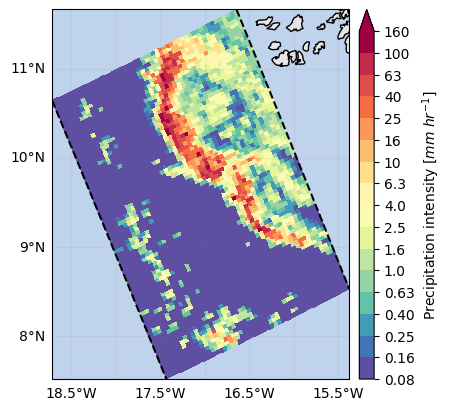

In [31]:
import gpm
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the path to your specific file
file_path = "/glade/u/home/rberrios/miniconda3/DRpy/2A.GPM.DPR.V920211125.20220914-S054128-E061127.V07A.RT-H5"

# 2. Open the specific granule
ds = gpm.open_granule(file_path)
print("Dataset loaded successfully.")

# --- DIAGNOSTIC: Check where the data actually is ---
min_lat = ds['lat'].min().values
max_lat = ds['lat'].max().values
min_lon = ds['lon'].min().values
max_lon = ds['lon'].max().values

print("\n--- Granule Coverage ---")
print(f"Latitude range:  {min_lat:.2f} to {max_lat:.2f}")
print(f"Longitude range: {min_lon:.2f} to {max_lon:.2f}")

# 3. Define the subset parameters
center_lat = 10.5
# Ensure longitude is in the same format as the dataset (-180 to 180)
center_lon = -16.0

print(f"\nTarget Center: Lat {center_lat}, Lon {center_lon}")

# Calculate the bounding box for a 2x2 degree map
extent = [
    center_lon - 1.0,
    center_lon + 1.0,
    center_lat - 2.0,
    center_lat + 1.0,
]

# 4. Attempt to subset the data
var_name = "precipRateNearSurface"
# Check if variable exists, fallback if not
if var_name not in ds:
    print(f"Warning: {var_name} not found. Switching to precipRateNearSurface.")
    var_name = "precipRateNearSurface"

try:
    print(f"Attempting to crop to extent: {extent}")
    ds_plot = ds.gpm.crop(extent=extent)
    print("Crop successful!")
    title_text = f"{var_name}\nCentered at {center_lat}, {center_lon}"
except ValueError as e:
    print(f"\nERROR: {e}")
    print("The satellite likely did not pass over your target coordinates in this file.")
    print("Plotting the ENTIRE granule instead so you can see the track.")
    ds_plot = ds
    title_text = f"{var_name} (Full Granule - Target Out of Bounds)"

# 5. Prepare DataArray for plotting
da = ds_plot[var_name]

# --- FIX: Handle extra dimensions like 'radar_frequency' ---
# 2A-DPR often has a 'radar_frequency' dimension (Ku vs Ka band).
# We must select one to make it a 2D map.
if "radar_frequency" in da.dims:
    print("Selecting 'Ku' band from radar_frequency dimension.")
    da = da.sel(radar_frequency="Ku")

# Squeeze out any other singular dimensions (like length-1 time dims)
da = da.squeeze()

# 6. Plot the data
plt.figure(figsize=(10, 6))

# Plot map
p = da.gpm.plot_map(
    cmap="Spectral_r",
    # vmin=15, 
    # vmax=45
)

# plt.title(title_text)
plt.show()

Multiple granules together.

Loading 2 granules...
'scan_mode' has not been specified. Default to FS.
Loaded: 2A.GPM.DPR.V920211125.20220914-S051128-E054127.V07A.RT-H5
'scan_mode' has not been specified. Default to FS.
Loaded: 2A.GPM.DPR.V920211125.20220914-S054128-E061127.V07A.RT-H5
Concatenation complete.

--- Combined Coverage ---
Latitude range:  -66.27 to 66.28
Longitude range: -158.56 to 102.24

Target Center: Lat 10.5, Lon -16.0
Attempting to crop to extent: [-17.5, -15.0, 8.5, 14.5]
Crop successful!


<Figure size 1000x600 with 0 Axes>

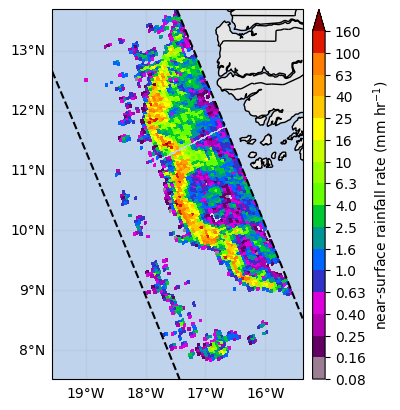

In [43]:
import gpm
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the paths to your specific files (in sequential order)
file_paths = [
    "/glade/u/home/rberrios/miniconda3/DRpy/2A.GPM.DPR.V920211125.20220914-S051128-E054127.V07A.RT-H5",
    "/glade/u/home/rberrios/miniconda3/DRpy/2A.GPM.DPR.V920211125.20220914-S054128-E061127.V07A.RT-H5"
]

print(f"Loading {len(file_paths)} granules...")

# 2. Open each granule and store in a list
datasets = []
for fp in file_paths:
    try:
        # open_granule loads a single file
        ds_single = gpm.open_granule(fp)
        datasets.append(ds_single)
        print(f"Loaded: {fp.split('/')[-1]}")
    except Exception as e:
        print(f"Error loading {fp}: {e}")

# 3. Concatenate them along the satellite track
if len(datasets) > 1:
    # 'along_track' is the dimension that represents time/motion of the satellite
    ds = xr.concat(datasets, dim="along_track")
    print("Concatenation complete.")
else:
    ds = datasets[0]

# --- DIAGNOSTIC: Check coverage of the combined dataset ---
min_lat = ds['lat'].min().values
max_lat = ds['lat'].max().values
min_lon = ds['lon'].min().values
max_lon = ds['lon'].max().values

print("\n--- Combined Coverage ---")
print(f"Latitude range:  {min_lat:.2f} to {max_lat:.2f}")
print(f"Longitude range: {min_lon:.2f} to {max_lon:.2f}")

# 4. Define the subset parameters
# (Using coordinates from your previous iteration)
center_lat = 10.5
center_lon = -16.0 

print(f"\nTarget Center: Lat {center_lat}, Lon {center_lon}")

# Calculate the bounding box for a 2x2 degree map
extent = [
    center_lon - 1.5,
    center_lon + 1.0,
    center_lat - 2.0,
    center_lat + 4.0,
]

# 5. Attempt to subset the combined data
var_name = "precipRateNearSurface"
if var_name not in ds:
    print(f"Warning: {var_name} not found. Switching to precipRateNearSurface.")
    var_name = "precipRateNearSurface"

try:
    print(f"Attempting to crop to extent: {extent}")
    ds_plot = ds.gpm.crop(extent=extent)
    print("Crop successful!")
    title_text = f"{var_name}\nCentered at {center_lat}, {center_lon}"
except ValueError as e:
    print(f"\nERROR: {e}")
    print("The satellite likely did not pass over your target coordinates in these files.")
    print("Plotting the ENTIRE combined dataset instead.")
    ds_plot = ds
    title_text = f"{var_name} (Full Swath - Target Out of Bounds)"

# 6. Prepare DataArray for plotting
da = ds_plot[var_name]

# Select Ku band if multiple frequencies exist
if "radar_frequency" in da.dims:
    print("Selecting 'Ku' band from radar_frequency dimension.")
    da = da.sel(radar_frequency="Ku")

# Squeeze out singular dimensions
da = da.squeeze()

# 7. Plot the data
plt.figure(figsize=(10, 6))

p = da.gpm.plot_map(
    cbar_kwargs={"label": r"near-surface rainfall rate (mm hr$^{-1}$)"},
    # cmap="RdYlBu_r",
    # vmin=15, 
    # vmax=45
)

# plt.title(title_text)
plt.savefig('./Figures/GPM_overpass_RF05.jpeg',bbox_inches='tight', dpi=600)
plt.show()